In [1]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(psych,warn.conflicts=F)
library(lplyr,warn.conflicts=F)
library(tidyr,warn.conflicts=F)

library(ggplot2,warn.conflicts=F)

In [2]:
# Final ranking of madness
data.teamtourneyranks <- readRDS('TeamTourneyRanking.rds')
# ranking mapping
data.tourneyranks <- read.csv('TourneyRanks.csv')# load ranking db
data.ranking <- readRDS('../datafiles_rds/MasseyOrdinals.rds')
# keep 2017, last day
data.ranking %>% 
    filter(Season==2017) %>%
    filter(RankingDayNum==max(RankingDayNum)) %>%
    select(-RankingDayNum) -> data.lastranking

In [3]:
# Keep only 68 tourney teams
data.lastranking %>%
    inner_join(data.teamtourneyranks,by=c('Season','TeamID')) %>% 
    group_by(Season,SystemName) %>% 
    summarise(n=n()) %>% 
    ungroup() %>% 
    filter(n==68) -> df.systems
data.lastranking %>%
    semi_join(df.systems,by=c('Season','SystemName')) -> df.ranking

#### Prepare 

In [4]:
data.matchups <- readRDS('../datafiles_rds/TourneyMatchups.rds')
data.matchups %>% 
    filter(Season==2017) -> data.matchups

In [5]:
df.ranking %>% 
    distinct(SystemName) %>%
    mutate(Season=2017) -> data.SystemName

In [6]:
data.matchups %>%
    inner_join(data.SystemName,by='Season') -> df.matchups

In [7]:
df.matchups %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.x'='TeamID')) %>%
    rename(Rank.x=OrdinalRank) %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.y'='TeamID')) %>%
    rename(Rank.y=OrdinalRank) -> df.matchups

In [8]:
Slope <- 3/(350/3)

In [9]:
df.matchups %>%
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rank.y-Rank.x,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(ID,SystemName,Pred,Prob) -> df.submit

#### Performance

In [10]:
data.truth <- readRDS('../datafiles_rds/TourneyTrueResults.rds')

In [11]:
df.submit %>%
    inner_join(data.truth,by='ID') -> df.results

In [12]:
df.results %>%
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) -> df.results
df.results %>%
    group_by(SystemName) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Accuracy=TC/N,LogLoss=-mean(LogLoss)) %>%
    ungroup() %>%
    select(SystemName,TC,FC,N,Accuracy,LogLoss) -> df.test.perf
df.test.perf %>% arrange(LogLoss) %>% head

SystemName,TC,FC,N,Accuracy,LogLoss
DOK,53,14,67,0.7910448,0.4934149
SP,49,18,67,0.7313433,0.4979757
SAG,50,17,67,0.7462687,0.4985588
YAG,48,19,67,0.7164179,0.5043567
RSL,49,18,67,0.7313433,0.5065233
CNG,49,18,67,0.7313433,0.5070323


#### Masters Predictors

In [13]:
df.results %>%
    group_by(ID) %>%
    summarise(CSS=sum(OK)) %>%
    arrange(CSS) -> toto

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


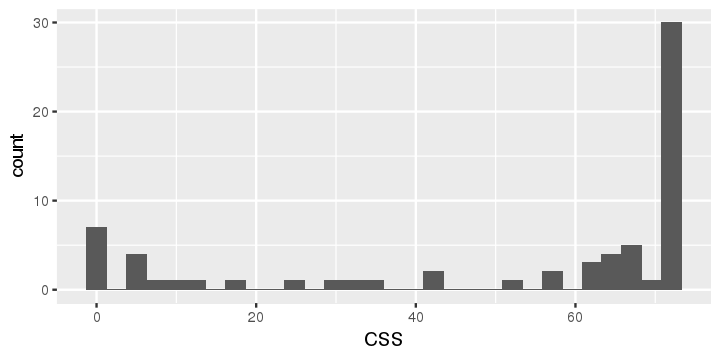

In [14]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(data=toto,aes(x=CSS)) + geom_histogram()

In [24]:
df.test.perf %>% arrange(desc(Accuracy),LogLoss) %>% head

SystemName,TC,FC,N,Accuracy,LogLoss
DOK,53,14,67,0.7910448,0.4934149
JRT,51,16,67,0.7611940,0.5149759
MCL,51,16,67,0.7611940,0.5774857
SAG,50,17,67,0.7462687,0.4985588
FMG,50,17,67,0.7462687,0.5157104
LMC,50,17,67,0.7462687,0.5183003


In [41]:
df.results %>%
#    filter(SystemName %in% c('MAS','WOL')) %>%
    filter(SystemName %in% c('DOK','JRT','MCL')) %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    mutate(W=ifelse(SystemName=='DOK',2,1)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(W*OK)) %>% 
    ungroup() %>%
    group_by(Tot) %>%
    summarise(n=n())

Tot,n
0,27
1,12
2,6
3,24
4,132


In [42]:
df.results %>%
#    filter(SystemName %in% c('MAS','WOL')) %>%
    filter(SystemName %in% c('DOK','JRT','MCL')) %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    mutate(W=ifelse(SystemName=='DOK',2,1)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(W*OK), mDelta=mean(Delta)) %>% 
    mutate_which(Tot>0 & Tot<4,Prob=0.5) %>%
    ungroup() %>%
    arrange(desc(Delta)) %>%
    group_by(ID) %>%
    slice(1:1) %>%
    ungroup() %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) -> df.masters

In [43]:
df.masters %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Accuracy=TC/N,LogLoss=-mean(LogLoss)) 

TC,N,FC,Accuracy,LogLoss
52,67,15,0.7761194,0.4875654


#### Challengers Predictors

### 2019

In [45]:
# load ranking db
data.ranking <- read.csv('../2019/Prelim2019_MasseyOrdinals.csv',stringsAsFactors=F)
# keep 2019, last day
data.ranking %>% 
    filter(Season==2019) %>%
#    filter(SystemName %in% c('MAS','WOL')) %>%
    filter(SystemName %in% c('DOK','JRT','MCL')) %>%
    filter(RankingDayNum==max(RankingDayNum)) %>%
    select(-RankingDayNum) -> data.lastranking

In [46]:
data.madnessteams <- read.csv('../2019//NCAATourneySeeds.csv',stringsAsFactors=F)
data.madnessteams %>% 
    filter(Season==2019) %>%
    select(Season,TeamID) -> data.madnessteams

In [47]:
data.madnessteams %>%
    full_join(data.madnessteams,by='Season') %>%
    filter(TeamID.x < TeamID.y) -> data.matchups 

In [48]:
data.lastranking %>% 
    #filter(SystemName %in% c('MAS','WOL')) -> df.ranking
    filter(SystemName %in% c('DOK','JRT','MCL')) -> df.ranking

In [49]:
df.ranking %>% 
    distinct(SystemName) %>%
    mutate(Season=2019) -> data.SystemName

In [50]:
data.matchups %>%
    inner_join(data.SystemName,by='Season') -> df.matchups

In [51]:
df.matchups %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.x'='TeamID')) %>%
    rename(Rank.x=OrdinalRank) %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.y'='TeamID')) %>%
    rename(Rank.y=OrdinalRank) -> df.matchups

In [52]:
Slope <- 3/(350/3)

In [53]:
df.matchups %>%
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rank.y-Rank.x,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(ID,SystemName,Pred,Prob) -> df.submit

In [54]:
df.submit %>% head

ID,SystemName,Pred,Prob
2019_1181_1277,DOK,1,0.526
2019_1181_1261,DOK,1,0.589
2019_1181_1439,DOK,1,0.570
2019_1181_1280,DOK,1,0.626
2019_1181_1268,DOK,1,0.650
2019_1181_1257,DOK,1,0.632


In [56]:
df.submit %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    mutate(W=ifelse(SystemName=='DOK',2,1)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(W*Pred), mDelta=mean(Delta)) %>% 
    mutate_which(Tot>0 & Tot<4,Prob=0.5) %>%
    ungroup() %>%
    arrange(desc(Delta)) %>%
    group_by(ID) %>%
    slice(1:1) %>%
    ungroup() -> df.masters.2019

In [57]:
df.submit %>% count
df.submit %>% sample_n(5)

n
2278


ID,SystemName,Pred,Prob
2019_1211_1233,DOK,1,0.950
2019_1278_1433,DOK,0,0.462
2019_1243_1246,DOK,0,0.405
2019_1234_1397,DOK,0,0.279
2019_1120_1295,DOK,1,0.950


In [58]:
# save the best results for kaggle submission
df.masters.2019 %>% 
    select(ID,Pred=Prob) %>% 
    write.csv('../predictions_2019/RankingTriMasters.csv',quote=F,row.names=F)

In [59]:
# save best model for mix
df.masters.2019 %>%
    saveRDS('../predictions_2019/RankingTriMasters.rds') 